Starting the transcriptomics analysis on 23/09/2024

> The ELF3 transcription factor is associated with an epithelial phenotype and represses epithelial-mesenchymal transition (Mar, 2023)

https://pubmed.ncbi.nlm.nih.gov/36864480/


In [ ]:
system('add-apt-repository -y ppa:cran/imagemagick')
system('apt-get update')
system("apt-get install libmagick++-dev")
install.packages("magick")

In [ ]:
install.packages("BiocManager")
BiocManager::install(c("GEOquery", "GSVA", "biomaRt"))
install.packages("ggplot2")
install.packages("dplyr")
install.packages("R.utils")
install.packages("ggrepel")

In [ ]:
library(R.utils)
library(GEOquery)
library(GSVA)
library(biomaRt)
library(ggplot2)
library(dplyr)
library(readxl)

# Figure A
 ### using R-libraries

In [ ]:
# Unzip the dataset
gunzip("CCLE_RNAseq_rsem_genes_tpm_20180929.txt.gz", remove = FALSE)

In [ ]:
# Read the unzipped file
ccle_data <- read.delim("CCLE_RNAseq_rsem_genes_tpm_20180929.txt", header = TRUE, sep = "\t")

# Remove the version suffix from Ensembl IDs in ccle_data
ccle_data$gene_id <- sub("\\..*", "", ccle_data$gene_id)

In [ ]:
# Set up the ensembl dataset
ensembl <- useEnsembl(biomart = "ensembl", dataset = "hsapiens_gene_ensembl")

# Get the mapping from Ensembl IDs to gene symbols
mapping <- getBM(
  attributes = c("ensembl_gene_id", "hgnc_symbol"),
  filters = "ensembl_gene_id",
  values = ccle_data$gene_id,
  mart = ensembl
)

# Merge the mapping with the CCLE data
ccle_data <- merge(ccle_data, mapping, by.x = "gene_id", by.y = "ensembl_gene_id")

In [ ]:
# Drop rows where there is no corresponding gene symbol
ccle_data <- ccle_data[ccle_data$hgnc_symbol != "", ]

# Remove rows with duplicated gene symbols
ccle_data_unique <- ccle_data[!duplicated(ccle_data$hgnc_symbol), ]

# Set the unique gene symbols as row names
rownames(ccle_data_unique) <- ccle_data_unique$hgnc_symbol

# Now remove the gene_id, transcript_ids and 'hgnc_symbol' column
ccle_data_unique <- ccle_data_unique[, -which(colnames(ccle_data_unique) %in% c('gene_id','transcript_ids', 'hgnc_symbol'))]

In [ ]:
# Ensure your expression data is in matrix format with genes as rows
ccle_expr_matrix <- as.matrix(ccle_data_unique)

In [ ]:
# Load the gene signature file
gene_signature <- read_excel("EM_gene_signature_tumor_KS.xlsx")

# Split genes based on Epi/Mes category
epithelial_genes <- gene_signature$Gene[gene_signature$Type == "Epi"]
mesenchymal_genes <- gene_signature$Gene[gene_signature$Type == "Mes"]

# Create a gene set list for ssGSEA
gene_sets <- list(
  epithelial = epithelial_genes,
  mesenchymal = mesenchymal_genes
)

In [ ]:
# Perform ssGSEA
ssgsea_param <- ssgseaParam(
  ccle_expr_matrix,
  gene_sets
)

ssgsea_scores <- gsva(ssgsea_param)

In [ ]:
# Transpose the expression matrix for correlation calculation
ccle_expr_t <- t(ccle_data_unique)

In [ ]:
# Calculate correlations with epithelial and mesenchymal scores
cor_results <- data.frame(
  gene = rownames(ccle_data_unique),
  cor_epithelial = apply(ccle_expr_t, 2, function(x) cor(x, ssgsea_scores["epithelial", ], method = "pearson")),
  cor_mesenchymal = apply(ccle_expr_t, 2, function(x) cor(x, ssgsea_scores["mesenchymal", ], method = "pearson"))
)

In [ ]:
# List of genes to highlight
highlight_genes <- c("VIM", "ZEB1", "SLUG", "SNAI2", "GRHL2", "OVOL2", "KLF4", "CDH1", "ELF3")

# Assign colors for the specific gene categories
cor_results <- cor_results %>%
  mutate(
    category = case_when(
      gene %in% mesenchymal_genes ~ "Mesenchymal",
      gene %in% epithelial_genes ~ "Epithelial",
      gene == "ELF3" ~ "ELF3",
      TRUE ~ "Other"
    ),
    color = case_when(
      category == "Mesenchymal" ~ "blue",
      category == "Epithelial" ~ "orange",
      category == "ELF3" ~ "red",
      TRUE ~ "grey"
    )
  )


Warning message:
“Removed 4008 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4008 rows containing missing values or values outside the scale range
(`geom_text()`).”


ERROR: [1m[33mError[39m:[22m
[1m[22m[33m![39m Can't add `geom_text_repel(aes(label = ifelse(gene %in% c("CDH1",
  "GRHL2", `, ` "VIM", "ZEB1", "SNAI1", "SNAI2", "ELF3"), gene, "")),
  box.padding = 0.5, `, and ` point.padding = 0.5, max.overlaps = 0)` to a
  theme object.


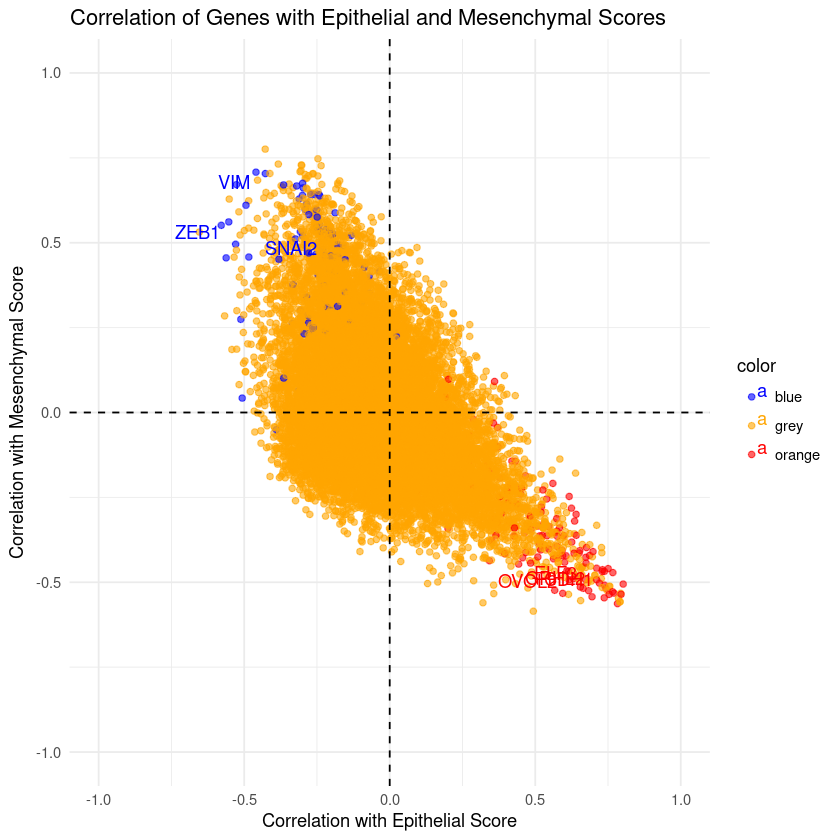

In [ ]:
library(ggplot2)
library(ggrepel)

# Create the scatter plot
ggplot(cor_results, aes(x = cor_epithelial, y = cor_mesenchymal, color = color, label = gene)) +
  geom_point(alpha = 0.6) +
  geom_text(aes(label = ifelse(gene %in% highlight_genes, gene, "")), hjust = 1.2, vjust = 1.2) +
  scale_color_manual(values = c("blue", "orange", "red", "grey")) +
  xlim(-1, 1) +  # Set x-axis limits
  ylim(-1, 1) +  # Set y-axis limits
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  labs(
    title = "Correlation of Genes with Epithelial and Mesenchymal Scores",
    x = "Correlation with Epithelial Score",
    y = "Correlation with Mesenchymal Score"
  ) +
  theme_minimal()

theme(legend.position = "none") +  # Remove the legend
  geom_text_repel(aes(label = ifelse(gene %in% c("CDH1", "GRHL2", "VIM", "ZEB1", "SNAI1", "SNAI2", "ELF3"), gene, "")),
                  box.padding = 0.5,   # Adjust padding
                  point.padding = 0.5,  # Padding around points
                  max.overlaps = 0)   # Allow for no overlaps

# Save the plot with an aspect ratio of 10:6
ggsave("scatter_plot.png", plot, width = 10, height = 6)

Warning message:
“Removed 4008 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4008 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“Removed 4008 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4008 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


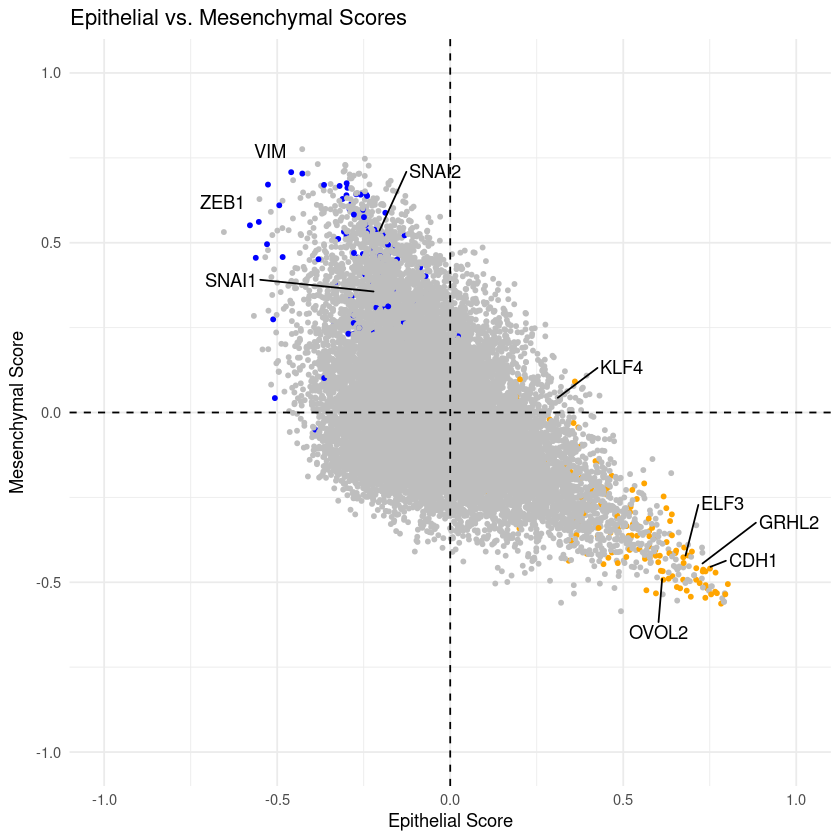

In [ ]:
library(ggplot2)
library(ggrepel)

# Create the plot
plot <- ggplot(cor_results, aes(x = cor_epithelial, y = cor_mesenchymal)) +
  geom_point(aes(color = ifelse(gene %in% mesenchymal_genes, "Mesenchymal",
                                 ifelse(gene %in% epithelial_genes, "Epithelial",
                                        ifelse(gene == "ELF3", "ELF3", "Other")))),
                 shape = 19, size = 1) +
  scale_color_manual(values = c("Mesenchymal" = "blue",
                                 "Epithelial" = "orange",
                                 "ELF3" = "red",
                                 "Other" = "gray")) +
  xlim(-1, 1) +  # Set x-axis limits
  ylim(-1, 1) +  # Set y-axis limits
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal line
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical line
  labs(title = "Epithelial vs. Mesenchymal Scores",
       x = "Epithelial Score",
       y = "Mesenchymal Score") +
  theme_minimal() +
  theme(legend.position = "none") +  # Remove the legend
  geom_text_repel(aes(label = ifelse(gene %in% c("CDH1", "GRHL2", "VIM", "ZEB1", "SNAI1", "SNAI2", "ELF3", "OVOL2", "KLF4"), gene, "")),
                  box.padding = 0.5,   # Adjust padding
                  point.padding = 0.5,  # Padding around points
                  max.overlaps = Inf)   # Allow for all overlaps

# Set the aspect ratio
ggsave("scatter_plot.png", plot, width = 10, height = 6, dpi = 300)

# To display the plot directly in the console, use:
print(plot)

#Figure B

In [ ]:
!wget -O Cell_lines_annotations_20181226.txt "https://data.broadinstitute.org/ccle/Cell_lines_annotations_20181226.txt"

In [ ]:
cell_line_annotation = pd.read_csv("Cell_lines_annotations_20181226.txt", sep="\t")

cell_line_annotation

,CCLE_ID,depMapID,Name,Pathology,Site_Primary,Site_Subtype1,Site_Subtype2,Site_Subtype3,Histology,Hist_Subtype1,...,Growth.Medium,Supplements,Freezing.Medium,Doubling.Time.from.Vendor,Doubling.Time.Calculated.hrs,type,type_refined,PATHOLOGIST_ANNOTATION,mutRate,tcga_code
0,DMS53_LUNG,ACH-000698,DMS 53,primary,lung,NS,NS,NS,carcinoma,small_cell_carcinoma,...,Waymouth's +10%FBS,NaN,5%DMSO,NaN,450.0,lung_small_cell,lung_small_cell,Lung:SCLC,157.241638,SCLC
1,SW1116_LARGE_INTESTINE,ACH-000489,SW1116,primary,large_intestine,colon,NS,NS,carcinoma,adenocarcinoma,...,L15+10%FBS,NaN,5%DMSO,NaN,123.2,colorectal,colorectal,Colorectal:Carcinoma,94.373192,COAD/READ
2,NCIH1694_LUNG,ACH-000431,NCI-H1694,metastasis,lung,NS,NS,NS,carcinoma,small_cell_carcinoma,...,DMEM:F12 (1:1) + 5% FBS,".005 mg/ml insulin, .01 mg/ml transferrin, 30n...",5% DMSO,NaN,81.2,lung_small_cell,lung_small_cell,Lung:SCLC,109.534987,SCLC
3,P3HR1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000707,P3HR-1,metastasis,haematopoietic_and_lymphoid_tissue,NS,NS,NS,lymphoid_neoplasm,Burkitt_lymphoma,...,NaN,NaN,NaN,NaN,NaN,lymphoma_Burkitt,lymphoma_Burkitt,Lymphoma:NH_B_cell,166.456406,DLBC
4,HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000509,HuT 78,primary,haematopoietic_and_lymphoid_tissue,skin,NS,NS,lymphoid_neoplasm,mycosis_fungoides-Sezary_syndrome,...,NaN,NaN,NaN,NaN,NaN,lymphoma_other,T-cell_lymphoma_other,Lymphoma:NH_T_cell,118.217569,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,GEO_LARGE_INTESTINE,ACH-002394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,colorectal,NaN,NaN,COAD/READ
1457,NCIH2330_LUNG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1458,LP6_SOFT_TISSUE,ACH-001116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1459,HS578BST_BREAST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Subset ccle_data for the desired gene ID
ccle_data_subset = ccle_data[ccle_data['Gene'] == 'ELF3']

# Transpose ccle_data_subset and reset index to preserve CCLE_ID
ccle_data_transposed = ccle_data_subset.T

# Add 'Site_Primary' column based on matching CCLE_ID
ccle_data_transposed['Site_Primary'] = ccle_data_transposed.iloc[:,0].map(
    lambda x: cell_line_annotation.loc[cell_line_annotation['CCLE_ID'] == x, 'Site_Primary'].iloc[0]
    if x in cell_line_annotation['CCLE_ID'].values else None
)

In [ ]:
import pandas as pd

# Extract ELF3 expression and Site_Primary from ccle_data_transposed
elf3_expression = ccle_data_transposed.loc['ELF3', ccle_data_transposed.columns[1:]]
site_primary = ccle_data_transposed.loc['Gene', ccle_data_transposed.columns[1:]]

# Create a DataFrame with ELF3 expression and Site_Primary
elf3_df = pd.DataFrame({'ELF3_Expression': elf3_expression, 'Site_Primary': site_primary})
elf3_df.index.name = 'Name' # Setting the index name for consistency
elf3_df = elf3_df.reset_index()

# Filter ssgsea_ccle_df for Epithelial and Mesenchymal scores
ssgsea_filtered = ssgsea_ccle_df[ssgsea_ccle_df['Term'].isin(['Epithelial', 'Mesenchymal'])]

# Merge ELF3 expression with filtered ssgsea data
merged_data = pd.merge(elf3_df, ssgsea_filtered, on='Name', how='inner')

# Calculate correlation coefficients grouped by 'Name'
correlation_df = merged_data.groupby('Name').apply(lambda x: pd.Series({
    'Epithelial_Correlation': x['ELF3_Expression'].corr(x['ES']),
    'Mesenchymal_Correlation': x['ELF3_Expression'].corr(x['ES'])
})).reset_index()

# Filter correlation_df for epithelial and mesenchymal correlations separately
epithelial_correlation = correlation_df[merged_data['Term'] == 'Epithelial']
mesenchymal_correlation = correlation_df[merged_data['Term'] == 'Mesenchymal']

#Figure C and D

## With TCGAbiolinks in R

Although the library is well-known, somehow for all the projects the memory (RAM) usage is overshooting in my PC as well as the lab's system

In [ ]:
# @title Install Libraries
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("TCGAbiolinks")
BiocManager::install("SummarizedExperiment")

In [ ]:
# @title Import Libraries

library(TCGAbiolinks)
library(SummarizedExperiment)
library(ggplot2)

In [ ]:
# @title Get Projects

# List of TCGA cancer projects
projects <- TCGAbiolinks:::getGDCprojects()$project_id

# Initialize empty list to store ELF3 expression data for each project
elf3_expr_list <- list()

projects <- projects[grepl('^TCGA',projects,perl=T)]

In [ ]:
# @title Download and Merge Data

# Loop through each project and download ELF3 expression data
for (project in projects) {
  query <- GDCquery(
    project = projects,
    data.category = "Transcriptome Profiling",
    data.type = "Gene Expression Quantification",
    workflow.type = "STAR - Counts"
  )

  GDCdownload(query)
  tcga_data <- GDCprepare(query)

  # Extract expression data for ELF3
  elf3_expr <- assay(tcga_data)["ELF3", ]

  # Store in list with cancer type
  elf3_expr_list[[project]] <- data.frame(SampleID = colnames(tcga_data), ELF3_expr = elf3_expr, CancerType = projects)
}

# Combine expression data from all cancer types
elf3_expr_data <- do.call(rbind, elf3_expr_list)

## With downloaded data from UCSC Xena Browser

Using Python from this step onwards

In [ ]:
# @title  Installing Libraries

!pip install gseapy pandas matplotlib seaborn mygene openpyxl


In [ ]:
#@title Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
import mygene

In [ ]:
!wget -O CCLE_RNAseq_rsem_genes_tpm_20180929.txt.gz "https://data.broadinstitute.org/ccle/CCLE_RNAseq_rsem_genes_tpm_20180929.txt.gz"

In [ ]:
import pandas as pd
import gzip

# File path to the gzipped CCLE data
file_path = 'CCLE_RNAseq_rsem_genes_tpm_20180929.txt.gz'

# Open the gzip file and read it into a pandas DataFrame
with gzip.open(file_path, 'rt') as f:
    ccle_data = pd.read_csv(f, sep='\t')


In [ ]:
ccle_data.head()

,Gene,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
0,TSPAN6,5.28,7.01,22.80,22.88,23.09,57.94,16.30,32.02,60.53,...,0.74,50.29,14.18,24.13,20.94,47.96,28.92,61.08,8.12,16.81
1,TNMD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,DPM1,73.38,108.99,56.51,45.39,99.28,98.95,79.68,125.99,89.59,...,41.71,103.70,97.07,104.97,96.86,119.50,64.09,109.13,139.23,56.20
3,SCYL3,9.76,16.76,2.58,3.25,2.73,3.11,2.69,2.69,2.83,...,5.60,7.76,2.96,5.84,4.17,5.06,4.94,5.91,15.96,13.76
4,FIRRM,24.51,13.32,10.86,5.26,9.27,31.61,9.62,10.45,15.90,...,20.21,12.84,11.38,14.58,22.13,9.58,13.35,17.40,17.45,11.53


In [ ]:
# @title Replace the Ensembl IDs with Gene Symbol

# Initialize MyGeneInfo client
mg = mygene.MyGeneInfo()

# Extract just the Ensembl gene ID without the version (split by dot '.')
ccle_data['ensembl_id'] = ccle_data['gene_id'].apply(lambda x: x.split('.')[0])

# Query MyGene.info to get gene symbols
# List of Ensembl IDs
ensembl_ids = ccle_data['ensembl_id'].tolist()

# Query the MyGene API to get the corresponding gene symbols
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')

# Convert the result to a DataFrame
gene_info_df = pd.DataFrame(gene_info)

# Merge gene symbols into the original ccle_data DataFrame
ccle_data = ccle_data.merge(gene_info_df[['query', 'symbol']], left_on='ensembl_id', right_on='query', how='left')


In [ ]:
# Remove rows where gene symbols couldn't be mapped
ccle_data = ccle_data[ccle_data['symbol'].notnull()]

# Drop unnecessary columns and rename 'symbol' to 'Gene'
ccle_data = ccle_data.rename(columns={'symbol': 'Gene'}).drop(['gene_id', 'ensembl_id', 'transcript_ids', 'query'], axis=1)

# Reorder the columns to have 'Gene' as the first column
cols = ['Gene'] + [col for col in ccle_data.columns if col != 'Gene']
ccle_data = ccle_data[cols]

In [ ]:
#@title Make the gene sets - Epi & Mes

import pandas as pd
import gseapy as gp
from gseapy import ssgsea

# Load gene sets (epithelial and mesenchymal) from your Excel file
gene_sets = pd.read_excel('EM_gene_signature_tumor_KS.xlsx')
epithelial_genes = gene_sets[gene_sets['Type'] == 'Epi']['Gene'].tolist()
mesenchymal_genes = gene_sets[gene_sets['Type'] == 'Mes']['Gene'].tolist()

# Prepare gene sets for ssGSEA
gene_sets_dict = {
    'Epithelial': epithelial_genes,
    'Mesenchymal': mesenchymal_genes
}


In [ ]:
# @title Calculate ssGSEA scores for CCLE cohort
ssgsea_ccle = gp.ssgsea(data=ccle_data, gene_sets=gene_sets_dict, sample_norm_method='rank', outdir=None)

# Convert the scores to a DataFrame
ssgsea_ccle_df = ssgsea_ccle.res2d

# Print the ssGSEA scores
#print(ssgsea_scores_df)

2024-10-06 22:28:04,533 [WARNING] Found duplicated gene names, values averaged by gene names!


In [ ]:
ssgsea_ccle_df

,Name,Term,ES,NES
0,OE19_OESOPHAGUS,Epithelial,17765.327641,1.112957
1,CL40_LARGE_INTESTINE,Epithelial,17729.982399,1.110742
2,JHOM2B_OVARY,Epithelial,17684.261037,1.107878
3,HCC1588_LUNG,Epithelial,17474.305997,1.094725
4,GSU_STOMACH,Epithelial,17460.926378,1.093887
...,...,...,...,...
2033,GSU_STOMACH,Mesenchymal,2637.546361,0.165236
2034,LS513_LARGE_INTESTINE,Mesenchymal,2539.188355,0.159074
2035,SNU16_STOMACH,Mesenchymal,2521.225216,0.157949
2036,CL34_LARGE_INTESTINE,Mesenchymal,2494.115381,0.156251


In [ ]:
ccle_data_transposed

,11111,Site_Primary
Gene,ELF3,None
22RV1_PROSTATE,37.68,prostate
2313287_STOMACH,162.92,stomach
253JBV_URINARY_TRACT,101.73,urinary_tract
253J_URINARY_TRACT,89.0,urinary_tract
...,...,...
YD8_UPPER_AERODIGESTIVE_TRACT,15.05,upper_aerodigestive_tract
YH13_CENTRAL_NERVOUS_SYSTEM,2.49,central_nervous_system
YKG1_CENTRAL_NERVOUS_SYSTEM,0.25,central_nervous_system
ZR751_BREAST,711.51,breast


In [ ]:
!wget -O tcga_dataset.txt.gz "https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/tcga_RSEM_gene_tpm.gz"

In [ ]:
import gzip
import shutil

# Extract the gzipped file
with gzip.open('tcga_dataset.txt.gz', 'rb') as f_in:
    with open('tcga_dataset.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("File extracted successfully") # 1m 37s with CPU and 27s with TPU


In [ ]:
# @title Calculate ssGSEA scores for TCGA PanCan dataset

tcga_data = pd.read_csv("tcga_dataset.txt", sep="\t")

In [ ]:
# @title Replace Ensembl IDs with Gene Symbol

# Initialize MyGeneInfo client
mg = mygene.MyGeneInfo()

# Extract just the Ensembl gene ID without the version (split by dot '.')
tcga_data['ensembl_id'] = tcga_data['sample'].apply(lambda x: x.split('.')[0])

# Query MyGene.info to get gene symbols
# List of Ensembl IDs
ensembl_ids = tcga_data['ensembl_id'].tolist()

# Query the MyGene API to get the corresponding gene symbols
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')

# Convert the result to a DataFrame
gene_info_df = pd.DataFrame(gene_info)

# Merge gene symbols into the original tcga_data DataFrame
tcga_data = tcga_data.merge(gene_info_df[['query', 'symbol']], left_on='ensembl_id', right_on='query', how='left')

# Remove rows where gene symbols couldn't be mapped
tcga_data = tcga_data[tcga_data['symbol'].notnull()]

# Drop unnecessary columns and rename 'symbol' to 'Gene'
tcga_data = tcga_data.rename(columns={'symbol': 'Gene'}).drop(['sample', 'ensembl_id', 'query'], axis=1)

# Reorder the columns to have 'Gene' as the first column
cols = ['Gene'] + [col for col in tcga_data.columns if col != 'Gene']
tcga_data = tcga_data[cols]

# Print final dataset with gene symbols and expression values for all samples
print(tcga_data.head())

In [ ]:
tcga_data

,Gene,TCGA-19-1787-01,TCGA-S9-A7J2-01,TCGA-G3-A3CH-11,TCGA-EK-A2RE-01,TCGA-44-6778-01,TCGA-F4-6854-01,TCGA-AB-2863-03,TCGA-C8-A1HL-01,TCGA-EW-A2FS-01,...,TCGA-DJ-A2QC-01,TCGA-A8-A09K-01,TCGA-61-1907-01,TCGA-IB-7885-01,TCGA-95-7947-01,TCGA-VQ-AA6F-01,TCGA-BR-8588-01,TCGA-24-2254-01,TCGA-DD-A115-01,TCGA-FV-A3I0-11
0,LINC02082,-9.9658,0.2998,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-1.3921,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-1.9379,-9.9658,-9.9658
2,ST8SIA5-DT,-3.8160,-3.0469,-9.9658,-9.9658,-5.5735,-9.9658,-3.4580,-9.9658,-5.0116,...,-6.5064,-9.9658,-9.9658,-9.9658,-6.5064,-9.9658,-9.9658,-5.5735,-9.9658,-9.9658
3,RAB4B,5.2998,4.8881,3.5572,4.2563,5.3162,4.5161,3.6242,4.9782,5.7035,...,5.4591,5.5364,4.7798,5.0514,6.1607,5.2814,3.9599,5.0760,4.0260,3.0876
5,TIGAR,3.5086,2.3019,0.0990,3.6184,3.5633,2.9109,2.1638,2.6624,1.2696,...,1.5998,2.8219,2.5876,2.6232,2.9525,3.0774,3.4384,2.2082,2.1541,-0.5756
6,LINC01224,0.8647,-1.0262,-9.9658,-9.9658,1.1316,0.9493,-9.9658,2.0535,0.4447,...,-2.9324,0.4125,1.0222,-1.7322,-4.6082,-0.4521,1.3511,3.1344,-1.3183,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60494,GABARAPL3,-9.9658,-2.9324,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-2.9324,-9.9658,-9.9658
60496,BATF3,1.2271,1.1577,0.2642,0.5069,1.5902,0.6880,-1.6394,1.0293,1.4600,...,1.1316,-0.7346,0.3573,2.5707,1.6140,0.9862,1.9490,0.9642,0.3115,0.6145
60499,PPP6R1,5.2661,4.8151,3.4358,5.2851,5.6436,5.5958,6.7544,4.4095,4.4081,...,5.1700,5.3667,4.1161,4.9552,6.0228,6.1252,5.1473,6.2593,4.4647,3.2174
60500,LOC101927377,-0.2159,-3.3076,-2.5479,-5.0116,-1.3548,-9.9658,-0.9132,-5.0116,-1.8836,...,1.7141,-2.6349,-0.2671,-4.2934,-1.7322,-1.6850,-3.6259,-0.5543,-2.3884,-3.0469


In [ ]:
# @title Calculate the ssGSEA score

ssgsea_tcga = gp.ssgsea(data=tcga_data, gene_sets=gene_sets_dict, sample_norm_method='rank', outdir=None)

# Convert the scores to a DataFrame
ssgsea_tcga_df = ssgsea_tcga.res2d

# Print the ssGSEA scores
#print(ssgsea_tcga_df)

2024-10-06 19:49:39,647 [WARNING] Found duplicated gene names, values averaged by gene names!


In [ ]:
# Load ELF3 expression data
elf3_expr_data = pd.read_csv("ELF3_TCGA.txt", sep="\t")

In [ ]:
elf3_expr_data

,Sample,ELF3_Expression,Cancer_Type
0,TCGA-EK-A3GK-01,11.470,CESC
1,TCGA-L5-A4OH-01,11.200,ESCA
2,TCGA-ZF-A9R7-01,11.100,BLCA
3,TCGA-S4-A8RM-01,11.050,PAAD
4,TCGA-CU-A3QU-01,10.950,BLCA
...,...,...,...
10530,TCGA-BT-A20N-11,-9.966,BLCA
10531,TCGA-ZF-AA54-01,-9.966,BLCA
10532,TCGA-OR-A5JI-01,-9.966,ACC
10533,TCGA-OR-A5KT-01,-9.966,ACC


In [ ]:
# Adjust the ssgsea_tcga_df to extract relevant information
ssgsea_tcga_df = ssgsea_tcga_df[['Name', 'Term', 'ES']].rename(columns={'Name': 'Sample'})
# Filter to only Epithelial and Mesenchymal scores
ssgsea_filtered = ssgsea_tcga_df[ssgsea_tcga_df['Term'].isin(['Epithelial', 'Mesenchymal'])]

# Pivot the data to have scores in separate columns
ssgsea_pivoted = ssgsea_filtered.pivot(index='Sample', columns='Term', values='ES').reset_index()

# Merge with ELF3 expression data
merged_data = pd.merge(elf3_expr_data, ssgsea_pivoted, on='Sample')


In [ ]:
merged_data

,Sample,ELF3_Expression,Cancer_Type,Epithelial,Mesenchymal
0,TCGA-EK-A3GK-01,11.470,CESC,17492.45334,9635.686406
1,TCGA-L5-A4OH-01,11.200,ESCA,17973.328956,10379.584759
2,TCGA-ZF-A9R7-01,11.100,BLCA,16898.971889,10361.831723
3,TCGA-S4-A8RM-01,11.050,PAAD,18888.890951,12940.898157
4,TCGA-CU-A3QU-01,10.950,BLCA,17269.400755,8866.534556
...,...,...,...,...,...
10530,TCGA-BT-A20N-11,-9.966,BLCA,6743.964944,17404.514241
10531,TCGA-ZF-AA54-01,-9.966,BLCA,7864.348203,15477.292877
10532,TCGA-OR-A5JI-01,-9.966,ACC,7937.685795,15021.947788
10533,TCGA-OR-A5KT-01,-9.966,ACC,8518.011959,14534.450825


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

correlation_df = pd.DataFrame()
# Calculate correlation coefficients
for i in merged_data:
  correlation_df['correlation_epithelial'] = merged_data['ELF3_Expression'][i].corr(merged_data['Epithelial'][i])
  correlation_df['correlation_mesenchymal'] = merged_data['ELF3_Expression'][i].corr(merged_data['Mesenchymal'][i])

# Plotting the correlations
plt.figure(figsize=(12, 6))
sns.scatterplot(data=correlation_melted, x='Epithe', y='Correlation', hue='Score_Type')
plt.xticks(rotation=90)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title('Correlation of ELF3 Expression with Epithelial and Mesenchymal Scores Across TCGA Cancer Types')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Cancer Type')
plt.legend(title='Score Type')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

correlation_df = pd.DataFrame()

# Calculate correlation coefficients for each cancer type
for cancer_type in merged_data['Cancer_Type'].unique():
    cancer_data = merged_data[merged_data['Cancer_Type'] == cancer_type]
    correlation_epithelial = cancer_data['ELF3_Expression'].corr(cancer_data['Epithelial'])
    correlation_mesenchymal = cancer_data['ELF3_Expression'].corr(cancer_data['Mesenchymal'])

    # Append results to correlation_df
    correlation_df = pd.concat([correlation_df, pd.DataFrame({
        'Cancer_Type': [cancer_type],
        'Epithelial_Correlation': [correlation_epithelial],
        'Mesenchymal_Correlation': [correlation_mesenchymal]
    })], ignore_index=True)

# Highlight specific cancer types
highlight_cancer_types = ['CHOL', 'PAAD', 'BRCA', 'UCS', 'STAD']
correlation_df['Highlight'] = correlation_df['Cancer_Type'].apply(lambda x: x in highlight_cancer_types)


In [ ]:
!pip install adjustText

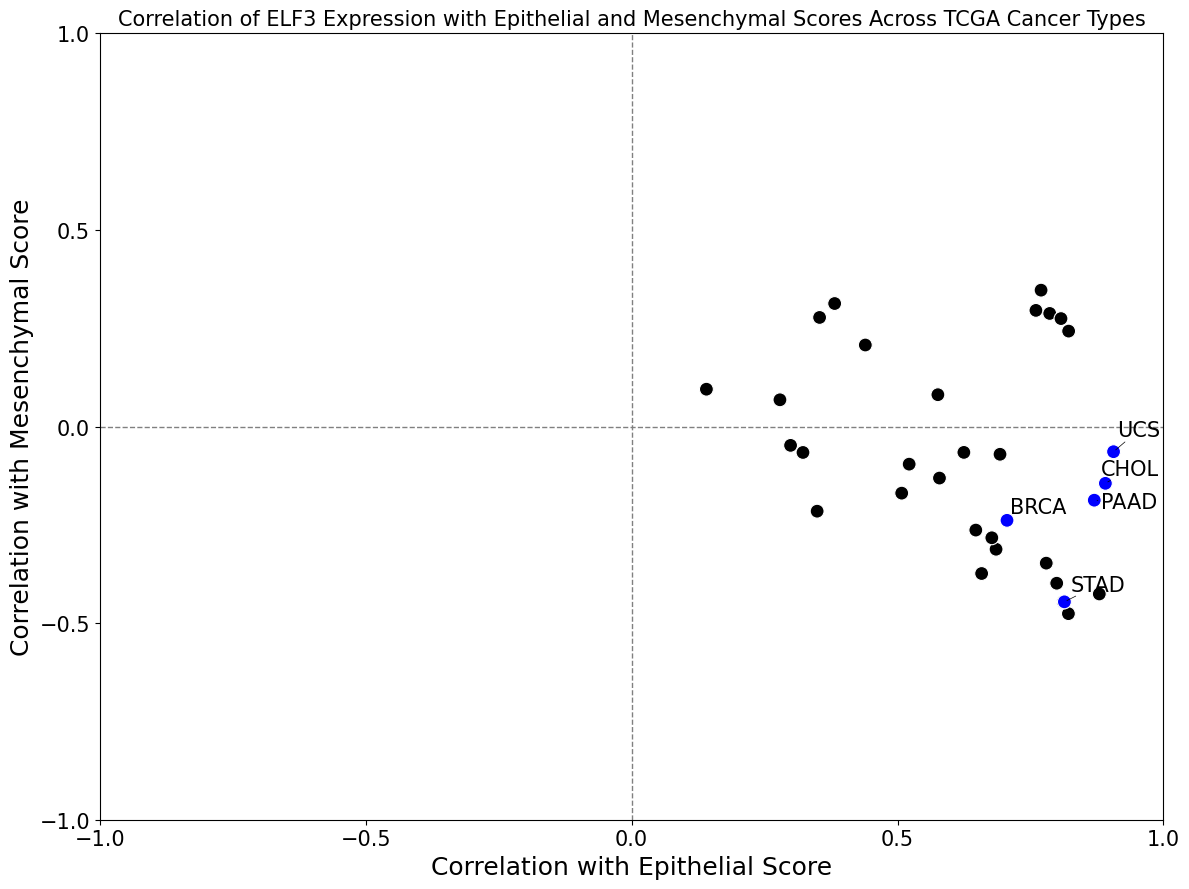

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Plotting the correlations
plt.figure(figsize=(12, 9))
sns.scatterplot(data=correlation_df, x='Epithelial_Correlation', y='Mesenchymal_Correlation',
                hue='Highlight', palette={True: 'blue', False: 'black'}, legend=False, s=100)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Correlation of ELF3 Expression with Epithelial and Mesenchymal Scores Across TCGA Cancer Types', fontsize=15)
plt.ylabel('Correlation with Mesenchymal Score', fontsize=18)
plt.xlabel('Correlation with Epithelial Score', fontsize=18)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xticks([-1, -0.5, 0, 0.5, 1], fontsize=15)
plt.yticks([-1, -0.5, 0, 0.5, 1], fontsize=15)

# Annotate highlighted points with adjust_text
texts = []
for idx, row in correlation_df[correlation_df['Highlight']].iterrows():
    texts.append(plt.text(row['Epithelial_Correlation'], row['Mesenchymal_Correlation'], row['Cancer_Type'],
                         ha='left', va='bottom', fontsize=15))

# Adjust text positions to avoid overlapping
# Adjust text positions to avoid overlapping with refined parameters
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5)) # Add connecting lines

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


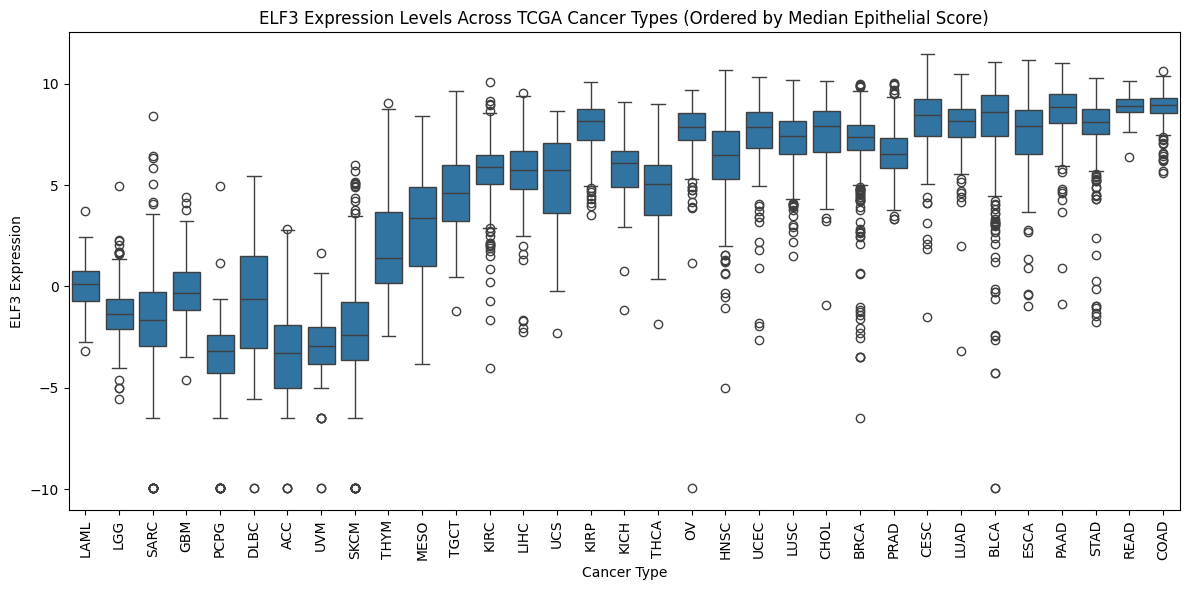

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate median epithelial scores for each cancer type
median_epithelial_scores = merged_data.groupby('Cancer_Type')['Epithelial'].median().sort_values()

# Order cancer types based on median epithelial scores
cancer_type_order = median_epithelial_scores.index

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='Cancer_Type', y='ELF3_Expression', order=cancer_type_order)
plt.xticks(rotation=90)

plt.ylabel('ELF3 Expression')
plt.xlabel('Cancer Type')
plt.tight_layout()
plt.show()

In [ ]:
merged_data['Epithelial'] = pd.to_numeric(merged_data['Epithelial'], errors='coerce')

<ipython-input-79-2de33db31d4f>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a colormap (blue to red)
<ipython-input-79-2de33db31d4f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, y='Cancer_Type', x='ELF3_Expression', order=cancer_type_order,
<ipython-input-79-2de33db31d4f>:18: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(data=merged_data, y='Cancer_Type', x='ELF3_Expression', order=cancer_type_order,
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with 

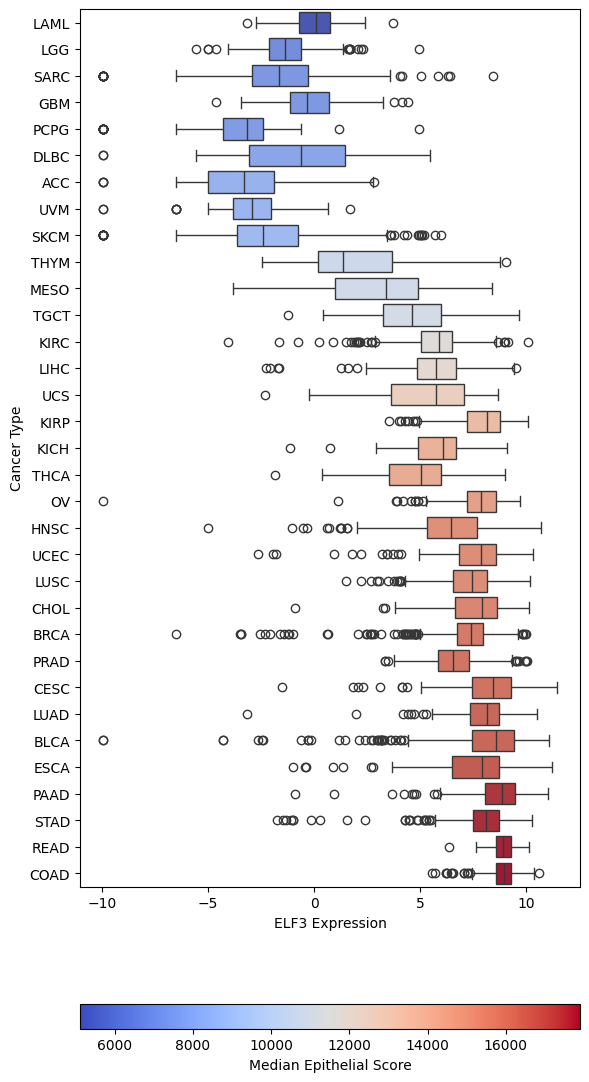

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Calculate median epithelial scores for each cancer type
median_epithelial_scores = merged_data.groupby('Cancer_Type')['Epithelial'].median().sort_values()

# Order cancer types based on median epithelial scores
cancer_type_order = median_epithelial_scores.index

# Create a colormap for the color bar
cmap = cm.get_cmap('coolwarm')  # Choose a colormap (blue to red)
norm = plt.Normalize(median_epithelial_scores.min(), median_epithelial_scores.max())  # Normalize scores for colormap

# Create the boxplot
plt.figure(figsize=(6, 12))  # Adjust figure size for portrait orientation
sns.boxplot(data=merged_data, y='Cancer_Type', x='ELF3_Expression', order=cancer_type_order,
            palette=cmap(norm(median_epithelial_scores.values)))  # Apply colormap to boxes
#plt.title('ELF3 Expression Levels Across TCGA Cancer Types (Ordered by Median Epithelial Score)')
plt.xlabel('ELF3 Expression')
plt.ylabel('Cancer Type')

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the colorbar
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.1)  # Create colorbar
cbar.set_label('Median Epithelial Score')

plt.tight_layout()
plt.savefig('elf3_expression_boxplot.png', dpi=300)  # Save with 300 DPI
plt.show()

# Figure E

## Plot-I

In [ ]:
!wget "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE118nnn/GSE118407/suppl/GSE118407%5FOVCA429shGRHL2%5Ffpkm.xlsx"

In [ ]:
import pandas as pd

GSE118407 = pd.read_excel("/content/GSE118407_OVCA429shGRHL2_fpkm.xlsx")

GSE118407

,GeneID,TranscriptIDs,GeneSymbol,Length,Effective Length,OVCA429sh12_L001.genes.results,OVCA429sh12_L002.genes.results,OVCA429sh12_L003.genes.results,OVCA429sh12_L004.genes.results,OVCA429shLuc_L001.genes.results,OVCA429shLuc_L002.genes.results,OVCA429shLuc_L003.genes.results,OVCA429shLuc_L004.genes.results
0,ENSG00000000003.10,"ENST00000373020.4,ENST00000494424.1,ENST000004...",TSPAN6,2138.28,1987.22,13.59,14.32,15.18,13.21,18.15,16.09,15.40,16.14
1,ENSG00000000005.5,"ENST00000373031.4,ENST00000485971.1",TNMD,940.50,789.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,ENSG00000000419.8,"ENST00000371582.4,ENST00000371583.5,ENST000003...",DPM1,1084.10,933.03,37.12,37.22,36.58,37.19,40.41,40.81,42.20,39.02
3,ENSG00000000457.9,"ENST00000367770.1,ENST00000367771.6,ENST000003...",SCYL3,4253.77,4102.70,3.69,3.02,2.57,3.71,2.35,2.41,3.06,2.23
4,ENSG00000000460.12,"ENST00000286031.6,ENST00000359326.4,ENST000004...",C1orf112,2135.91,1984.85,5.76,7.95,8.02,6.04,12.12,10.44,12.01,11.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57815,ENSGR0000264819.1,ENSTR0000580687.1,BX649553.4,74.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57816,ENSGR0000265350.1,ENSTR0000577896.1,RN7SL355P,314.00,163.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57817,ENSGR0000265658.1,ENSTR0000580266.1,MIR3690,75.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57818,ENSGR0000266731.1,ENSTR0000577553.1,AL732314.1,101.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
elf3_i = GSE118407[GSE118407['GeneSymbol'] == 'ELF3']
elf3_i

,GeneID,TranscriptIDs,GeneSymbol,Length,Effective Length,OVCA429sh12_L001.genes.results,OVCA429sh12_L002.genes.results,OVCA429sh12_L003.genes.results,OVCA429sh12_L004.genes.results,OVCA429shLuc_L001.genes.results,OVCA429shLuc_L002.genes.results,OVCA429shLuc_L003.genes.results,OVCA429shLuc_L004.genes.results
11111,ENSG00000163435.11,"ENST00000359651.3,ENST00000367283.3,ENST000003...",ELF3,1647.45,1496.39,5.85,6.29,4.75,9.55,132.74,123.55,127.6,122.07


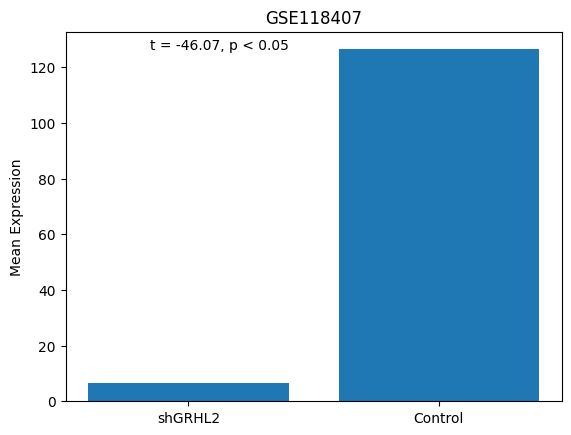

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Extract data for shGRHL2 (columns 5 to 8) and control (columns 9 to 12)
shGRHL2_data = pd.to_numeric(elf3_i.iloc[0, 5:9].values)
control_data = pd.to_numeric(elf3_i.iloc[0, 9:13].values)

# Calculate the t-test
t_statistic, p_value = stats.ttest_ind(shGRHL2_data, control_data)

# Prepare data for bar plot
data = [np.mean(shGRHL2_data), np.mean(control_data)]
labels = ['shGRHL2', 'Control']

# Create the bar plot
plt.bar(labels, data)
#plt.xlabel('Groups')
plt.ylabel('Mean Expression')
plt.title('GSE118407')


# Add t-test results
plt.text(0.4, max(data), f't = {t_statistic:.2f}, p < 0.05', ha='right')

plt.show()


## II

In [ ]:
!wget "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE61nnn/GSE61220/suppl/GSE61220_EMTrawcnts2.txt.gz"

In [ ]:
GSE61220 = pd.read_csv("/content/GSE61220_EMTrawcnts2.txt.gz", sep="\t")

GSE61220

,Unnamed: 0,Epi_Control_rep1,Epi_Control_rep2,Epi_Control_rep3,Mes_Control_rep1,Mes_Control_rep2,Mes_Control_rep3,Epi_TNF_1hr_rep1,Epi_TNF_1hr_rep2,Epi_TNF_1hr_rep3,Mes_TNF_1hr_rep1,Mes_TNF_1hr_rep2,Mes_TNF_1hr_rep3,Epi_TNF_12hr_rep1,Epi_TNF_12hr_rep2,Epi_TNF_12hr_rep3,Mes_TNF_12hr_rep1,Mes_TNF_12hr_rep2,Mes_TNF_12hr_rep3
0,A1BG,11,7,5,25,33,38,6,9,14,37,40,86,6,9,9,64,74,41
1,A1BG-AS1,1,2,4,12,9,20,1,5,6,13,9,17,8,6,5,20,16,17
2,A1CF,2,5,7,20,17,22,2,3,2,5,12,4,7,8,6,13,11,15
3,A2M,1,1,3,4,5,4,0,2,4,6,4,4,1,6,4,6,2,3
4,A2M-AS1,7,2,19,15,21,25,10,3,14,22,21,12,20,14,12,37,36,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16359,ZXDC,2229,1876,3068,1944,1795,2705,1268,1351,2669,1910,1752,852,2676,2916,2567,2677,3078,2175
16360,ZYG11B,933,919,2055,1127,1119,1317,738,862,1848,1289,1082,827,1547,1535,1402,1743,1608,1215
16361,ZYX,21865,17892,24048,20925,18704,28881,11308,10984,20001,21754,22257,9925,13226,14174,12849,28848,37561,21471
16362,ZZEF1,3147,2646,4423,2828,2632,3775,1824,2100,4191,2880,2804,1545,3577,3790,3253,3818,4351,2951


In [ ]:
# Filter rows where the first column (Unnamed: 0) contains 'ELF3'
elf3_ii = GSE61220[GSE61220['Unnamed: 0'].str.contains(r'^ELF3')]

# Display the filtered dataframe
elf3_ii


,Unnamed: 0,Epi_Control_rep1,Epi_Control_rep2,Epi_Control_rep3,Mes_Control_rep1,Mes_Control_rep2,Mes_Control_rep3,Epi_TNF_1hr_rep1,Epi_TNF_1hr_rep2,Epi_TNF_1hr_rep3,Mes_TNF_1hr_rep1,Mes_TNF_1hr_rep2,Mes_TNF_1hr_rep3,Epi_TNF_12hr_rep1,Epi_TNF_12hr_rep2,Epi_TNF_12hr_rep3,Mes_TNF_12hr_rep1,Mes_TNF_12hr_rep2,Mes_TNF_12hr_rep3
4064,ELF3,58,56,96,10,4,7,177,181,363,7,4,9,323,397,306,18,20,14


In [ ]:
elf3_ii.columns

Index(['Unnamed: 0', 'Epi_Control_rep1', 'Epi_Control_rep2',
       'Epi_Control_rep3', 'Mes_Control_rep1', 'Mes_Control_rep2',
       'Mes_Control_rep3', 'Epi_TNF_1hr_rep1', 'Epi_TNF_1hr_rep2',
       'Epi_TNF_1hr_rep3', 'Mes_TNF_1hr_rep1', 'Mes_TNF_1hr_rep2',
       'Mes_TNF_1hr_rep3', 'Epi_TNF_12hr_rep1', 'Epi_TNF_12hr_rep2',
       'Epi_TNF_12hr_rep3', 'Mes_TNF_12hr_rep1', 'Mes_TNF_12hr_rep2',
       'Mes_TNF_12hr_rep3'],
      dtype='object')

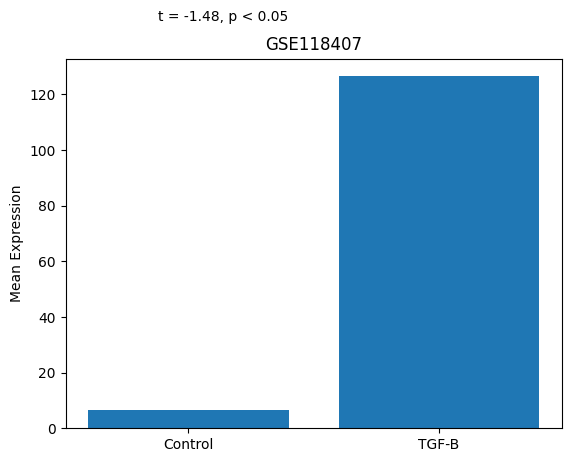

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Extract data
tgfb_data = pd.to_numeric(elf3_ii.iloc[0, 1:6].values)
control_ii_data = pd.to_numeric(elf3_ii.iloc[0, 7:12].values)

# Calculate the t-test
#t_statistic, p_value = stats.ttest_ind(tgfb_data, control_ii_data)

# Prepare data for bar plot
data_ii = [np.mean(tgfb_data), np.mean(control_ii_data)]
labels = ['Control', 'TGF-B']

# Create the bar plot
plt.bar(labels, data)
#plt.xlabel('Groups')
plt.ylabel('Mean Expression')
plt.title('GSE61220')


# Add t-test results
plt.text(0.4, max(data_ii), f't = {t_statistic:.2f}, p < 0.05', ha='right')

plt.show()
